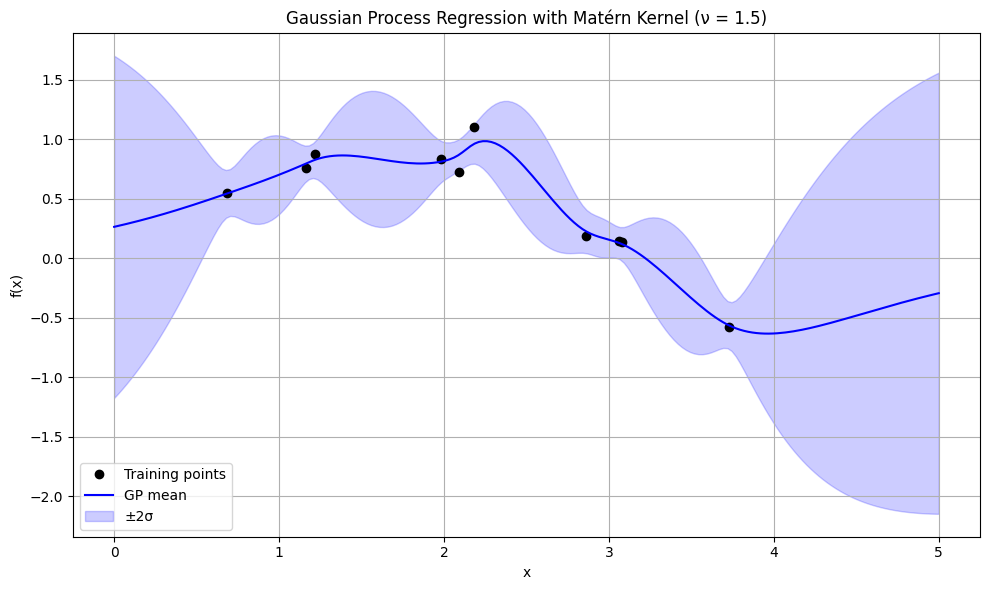

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma

# Matérn 3/2 kernel (ν = 1.5)
def matern_kernel(x1, x2, length_scale=1.0, sigma_f=1.0, nu=1.5):
    x1, x2 = np.atleast_2d(x1), np.atleast_2d(x2)
    r = cdist(x1, x2, metric='euclidean')
    if nu == 1.5:
        sqrt3_r = np.sqrt(3) * r / length_scale
        return sigma_f**2 * (1 + sqrt3_r) * np.exp(-sqrt3_r)
    elif nu == 2.5:
        sqrt5_r = np.sqrt(5) * r / length_scale
        return sigma_f**2 * (1 + sqrt5_r + 5*r**2/(3*length_scale**2)) * np.exp(-sqrt5_r)
    else:
        raise NotImplementedError("Only ν=1.5 and ν=2.5 are implemented.")

# Training data
X_train_matern = np.sort(np.random.uniform(0, 5, 10)).reshape(-1, 1)
y_train_matern = np.sin(X_train_matern).ravel() + 0.1 * np.random.randn(len(X_train_matern))

# Test points
X_test_matern = np.linspace(0, 5, 200).reshape(-1, 1)

# Hyperparameters
ell = 1.0        # length scale
sigma_f = 1.0    # signal std
sigma_n = 0.1    # observation noise std
nu = 1.5         # smoothness
p = nu - 0.5 # p = ν - 0.5 for Matérn kernel

# Compute kernels
K = matern_kernel(X_train_matern, X_train_matern, ell, sigma_f, nu) + sigma_n**2 * np.eye(len(X_train_matern))
K_s = matern_kernel(X_train_matern, X_test_matern, ell, sigma_f, nu)
K_ss = matern_kernel(X_test_matern, X_test_matern, ell, sigma_f, nu)

# GPR predictive mean and covariance
K_inv = np.linalg.inv(K)
mu_s = K_s.T @ K_inv @ y_train_matern
cov_s = K_ss - K_s.T @ K_inv @ K_s
std_s = np.sqrt(np.diag(cov_s))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mu_s, 'b-', label="GP mean")
plt.fill_between(X_test_matern.ravel(), mu_s - 2*std_s, mu_s + 2*std_s,
                 alpha=0.2, color='blue', label="±2σ")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Gaussian Process Regression with Matérn Kernel (ν = 1.5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[ 0.31400174  0.32144135  0.32892831  0.33645172  0.34399966  0.35155907
  0.35911572  0.3666541   0.37415733  0.38160711  0.38898357  0.39626519
  0.40342873  0.41044904  0.417299    0.42394937  0.43036866  0.43652298
  0.44237588  0.44788822  0.45301798  0.45772007  0.46194617  0.46564451
  0.46875966  0.47123231  0.47299903  0.47399204  0.47415647  0.47460793
  0.47614698  0.47870941  0.48222358  0.48661974  0.49182975  0.49778681
  0.50442519  0.51167994  0.51948665  0.52778115  0.53649927  0.54557655
  0.55494795  0.5645476   0.5743085   0.58416224  0.59403869  0.60386572
  0.60618068  0.59890885  0.54410758  0.50517923  0.44688864  0.35322704
  0.26820209  0.19137056  0.12231934  0.06066408  0.00604801 -0.04185917
 -0.08336238 -0.11874214 -0.14825544 -0.17213666 -0.19059829 -0.20383166
 -0.21200763 -0.21527716 -0.21377186 -0.20760449 -0.19686937 -0.18164277
 -0.16198325 -0.13793191 -0.10951264 -0.07673228 -0.03958078  0.00196878
  0.04796011  0.09845373  0.15352704  0.21327447  0

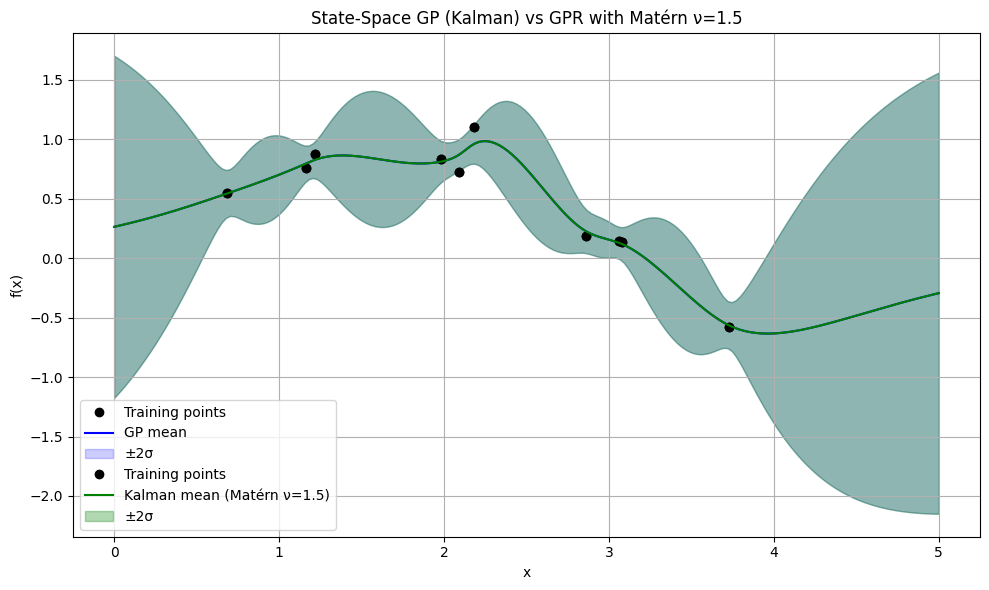

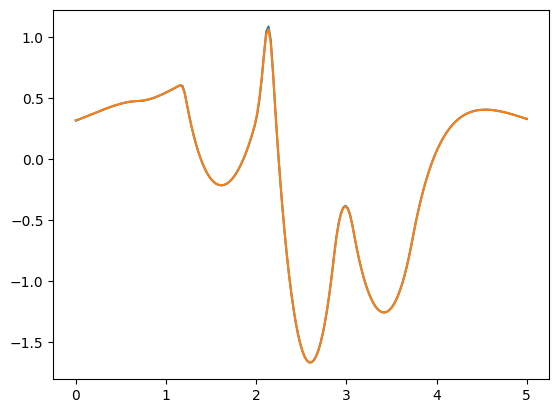

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_lyapunov
from scipy.special import gamma
from gp_preprocessor import gp_matern_fast

ell = 1.0
sigma_f = 1.0
sigma_n = 0.1

X_train = X_train_matern.flatten()
y_train = y_train_matern
X_test = X_test_matern.flatten()

mean_test, std_test, gradient_test = gp_matern_fast(X_train, y_train, X_test, ell, sigma_f, sigma_n)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mu_s, 'b-', label="GP mean")
plt.fill_between(X_test_matern.ravel(), mu_s - 2*std_s, mu_s + 2*std_s,
                 alpha=0.2, color='blue', label="±2σ")
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mean_test, 'g-', label="Kalman mean (Matérn ν=1.5)")
plt.fill_between(X_test_matern.ravel(), mean_test - 2*std_test, mean_test + 2*std_test,
                 alpha=0.3, color='green', label="±2σ")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("State-Space GP (Kalman) vs GPR with Matérn ν=1.5")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Do a quick numeric derivative to validate gradient
gradient_confirm = np.gradient(mean_test, X_test_matern.ravel())

plt.figure()
plt.plot(X_test_matern, gradient_test)
plt.plot(X_test_matern, gradient_confirm)
